In [1]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib 
import time
import os
import json

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from data import split_data

## I will need to clean stations names so they don't include any non-english value (tildes for example)

In [2]:
# Stationarity 
# stations = set(train.columns) - set(['day', 'hour', 'weekday', 'year', 'month', 'dayofweek'])

# stations = set(train.columns[train.columns.str.contains("\(")])

# to_drop_stations = []
# for station in stations:
#     s = train[station]

#     #Don't include stations with little data 
#     if s.sum() != 0:
#         ttest, diff = pm.arima.ADFTest().should_diff(s)
        
#         if diff: 
#             logging.info('{} is not stationary'.format(station)) 
            
#         # else: 
#         #     fit_arima(s[-20000:], station)
    
#     else: 
#         logging.info('No data available for station {} for the training period'.format(station)) 
#         to_drop_stations.append(station)

# #Final stations 
# stations = stations - set(to_drop_stations)

In [3]:
def delete_files_folder(directory):
    logging.info('Overwrite True. Deleting files in {}'.format(directory)) 
    for f in os.listdir(directory):
        os.remove(os.path.join(directory, f))

def read_plk(directory):
    fpath = os.path.join(directory)
    plk = joblib.load(fpath)
    return plk

def save_json(path, dictionary):
    a_file = open(path, "w")
    json.dump(dictionary, a_file)
    a_file.close()

In [4]:
'jasdf.plk'.split('.plk')
'jasdf.plk'[:-4]

'jasdf'

In [5]:
class arima():
    def __init__(self, directory, data_directory, aggregation, transformation):
        self.directory = directory
        self.data_directory = data_directory
        self.aggregation = aggregation 
        self.transformation = transformation 

        if aggregation == 'day':
            self.forecast_window = 7
        elif aggregation == 'hour':
            self.forecast_window = 24
        elif aggregation == 'month':
            self.forecast_window = 12
        elif aggregation == '15mins':
            self.forecast_window = 8
        else:
            raise KeyError ('aggregation parameter is one of [day, hour, month, 15 mins]')

        train, test = split_data(self.data_directory, 
            aggreagation= self.aggregation, 
            transformation = self.transformation)
        
        self.train = train 
        self.test = test
        self.stations = set(train.columns[train.columns.str.contains("\(")])

    def stationarity():
        return None

    def fit_arima(self, name):
        out_folder = self.directory
        s = self.train[name]

        start = time.time()
        #Model estimation
        arima_model = pm.auto_arima(s, start_p=1, start_q=1, max_p=10, max_q=10, seasonal=False,
                        stepwise=True, suppress_warnings=True, error_action='ignore', d = 0)
        
        # Persist file
        pickle_tgt = os.path.join(out_folder, 'models', aggregation, 'train', name + '.pkl')
        joblib.dump(arima_model, pickle_tgt, compress=3)
        end = time.time()
        
        #logging info
        time_elapsed = (end - start)/60
        logging.info('Model for station {} compleated. Time {:.2f} minutes'.format(name, time_elapsed)) 
        del arima_model

    def train_all(self, overwrite = False):
        out_folder = os.path.join(self.directory , 'models', aggregation, 'train')
        train = self.train

        if overwrite:
            delete_files_folder(out_folder)
        
        stations = self.stations
        # stations = set(train.columns[train.columns.str.contains("\(")]) #FIX ME: There are 29 stations that do exist but marked as non existing :(
            ## Examples: (07200) Tygua-San José
            ##  (07108) Av. El Dorado
            ## (06108) Concejo de Bogotá
        estimated_stations = os.listdir(out_folder)
        # estimated_stations = set([x.split('.plk')[0] for x in estimated_stations]) #removes extension in file name
        estimated_stations = set([x[:-4] for x in estimated_stations]) #removes extension in file name
        remaining_stations = stations - estimated_stations
        logging.info('{} stations do not have an estimated model. Starting estimation...'.format(len(remaining_stations))) 

        for name in remaining_stations:
            s = train[name]
            if s.sum() == 0:
                logging.info('No data available for station {} for the training period. No model estimation'.format(name)) 
            else:
                self.fit_arima(name)
    
    def predict(self, name):
        
        # if period == 'pre':
        #     df = self.pre
        #     folder = 'train'
        # elif period == 'post':
        #     df = self.post
        #     folder = 'pre'
        # else:
        #     raise KeyError ('period is either pre or post')

        df = self.test
        aggregation = self.aggregation
        input_folder = os.path.join(self.directory, 'models', aggregation, 'train', name + '.pkl')
        model = read_plk(input_folder)

        counter = 0
        first_prediction = True
        prediction_list = []
        s = df[name]
        start_value = s.index[0]
        
        start = time.time()
        for value in s.loc[start_value:]:
        
            if first_prediction:
                prediction = model.predict(self.forecast_window)
                prediction_list.append(prediction.tolist())
                first_prediction = False
            
            else:
                model.update(value)
                prediction = model.predict(self.forecast_window)
                prediction_list.append(prediction.tolist())  
            
            counter += 1
            # if counter % 100 == 0:
            #     end = time.time()
            #     time_elapsed = (end - start)/60
            #     logging.info('Iteration {}th. Time {:.2f} minutes'.format(counter, time_elapsed)) 
            #     start = time.time()
        
        # Persist the model as pkl for another future predictions. 
        pickle_tgt = os.path.join(self.directory, 'models', aggregation, 'test', name + '.pkl')
        joblib.dump(model, pickle_tgt, compress=3)
        
        return prediction_list

    def predict_all(self, overwrite = False):
        directory = self.directory
        aggregation = self.aggregation
        out_folder = os.path.join(directory, 'results', aggregation)

        stations = self.stations

        if overwrite:
            delete_files_folder(out_folder)
        
        predicted_stations = os.listdir(out_folder)
        # predicted_stations = set([x.split('.j')[0] for x in predicted_stations])#removes extension in file name
        predicted_stations = set([x[:-5] for x in predicted_stations]) #removes extension in file name
        remaining_stations = stations - predicted_stations
        logging.info('{} stations do not have a prediction. Prediction starting...'.format(len(remaining_stations))) 

        for name in remaining_stations:
            logging.info('Initialize prediction for {}.'.format(name)) 

            try: 
                start = time.time()
                predict = self.predict(name)
                end = time.time()
                logging.info('Finished prediction for {}. Time {:.2f} minutes'.format(name, end-start)) 
                
                dict_ = {}
                dict_['name'] = name
                dict_['prediction'] = predict
                out_folder_path = os.path.join(out_folder, name + '.json')
                save_json(out_folder_path, dict_)
            except FileNotFoundError: 
                logging.info('Station {}  not included - pass '.format(name))

In [2]:
a = set(['a','b','c','b'])

In [4]:
a[:2]

TypeError: 'set' object is not subscriptable

In [6]:
directory = 'output/arima'
data_directory = 'data'
aggregation = 'day'
transformation = 'log'
station = '(02101) Toberín'
arima_models = arima(directory, data_directory, aggregation, transformation)

In [8]:
arima_models.train_all(overwrite=True)

KeyboardInterrupt: 

INFO:root:Overwrite True. Deleting files in output/arima/models/day/train
INFO:root:151 stations do not have an estimated model. Starting estimation...


In [13]:
arima_models.predict_all(overwrite = False)

INFO:root:113 stations do not have a prediction. Prediction starting...
INFO:root:Initialize prediction for (05101) Mandalay - Cr.73.
INFO:root:Finished prediction for (05101) Mandalay - Cr.73. Time 827.80 minutes
INFO:root:Initialize prediction for (40002) Manitas.
INFO:root:Station (40002) Manitas  not included - pass 
INFO:root:Initialize prediction for (14004) Museo del Oro.
INFO:root:Finished prediction for (14004) Museo del Oro. Time 766.06 minutes
INFO:root:Initialize prediction for (07002) MADELENA.
INFO:root:Finished prediction for (07002) MADELENA. Time 1002.69 minutes
INFO:root:Initialize prediction for (07108) Av. El Dorado.
INFO:root:Finished prediction for (07108) Av. El Dorado. Time 67.93 minutes
INFO:root:Initialize prediction for (07505) LEON XIII.
INFO:root:Finished prediction for (07505) LEON XIII. Time 921.67 minutes
INFO:root:Initialize prediction for (02201) Prado.
INFO:root:Finished prediction for (02201) Prado. Time 910.18 minutes
INFO:root:Initialize prediction

In [25]:
prediction = arima_models.predict(name = station, period= 'pre')

In [30]:
prediction_post = arima_models.predict(name = station, period= 'post')

In [31]:
prediction.shape

(578, 7)

In [32]:
prediction_post.shape

(427, 7)

In [14]:
pre_data = arima_models.pre[station]

In [20]:
station = '(05102) Av. Américas - Av. Boyacá'
arima_models.pre[station]

1096    312.613730
1097    309.139412
1098    311.920589
1099    289.762085
1100    211.847241
           ...    
1669    306.920271
1670    310.585497
1671    309.908722
1672    315.078522
1673    297.650227
Name: (05102) Av. Américas - Av. Boyacá, Length: 578, dtype: float64

In [56]:
def read_target(station, type = 'pre'):
    if type == 'pre':
        data = arima_models.pre[station]
    elif type == 'post':
        data = arima_models.post[station]
    shift_list = []
    col_list = []
    for i in range(7):
        shift_list.append(data.shift(-i))
        col_list.append('forecast_period_' + str(i + 1))
    target = pd.concat(shift_list, axis = 1)
    target.columns = col_list
    target = np.array(target.dropna())
    return target

In [76]:
def read_forecast(station, type = 'pre'):
  path_to_file = os.path.join('output/arima/results/day', station + '.json' )
  with open(path_to_file) as f:
    forecast = json.load(f)

  if type == 'pre':
    forecast = np.array(forecast['pre_predict'])[:572,:]
  elif type == 'post':
    forecast = np.array(forecast['post_predict'])[:421,:]
  return forecast

In [162]:
def metrics_station(target, forecast):
    error = target - forecast
    PE = np.divide(error, target, out=np.zeros_like(error), where=target!=0)
    APE = np.abs(PE[PE!=0])
    return np.mean(APE), np.std(APE)

In [161]:
target = pre_forecast
forecast = pre_target

error = target - forecast
PE = np.divide(error, target, out=np.zeros_like(error), where=target!=0)

In [159]:
PE[PE!=0]

array([-0.01623146, -0.01908887, -0.02440649, ..., -0.01038386,
       -0.07341687, -0.24085772])

In [163]:
pre_forecast = read_forecast(station, type = 'pre')
pre_target = read_target(station, type = 'pre')
post_forecast = read_forecast(station, type = 'post')
post_target = read_target(station, type = 'post')

In [164]:
pre_MAPE, pre_VAPE = metrics_station(pre_target, pre_forecast)
post_MAPE, post_VAPE = metrics_station(post_target, post_forecast)

In [165]:
out_folder = 'output/arima/results/day'
stations_list = os.listdir(out_folder)
stations_list = [x.split('.json')[0] for x in stations_list]#removes extension in file name

In [166]:
pre_MAPE_list = []
post_MAPE_list = []
pre_VAPE_list = []
post_VAPE_list = []
problematic_stations = []
for station in stations_list:
    try: 
        pre_forecast = read_forecast(station, type = 'pre')
        pre_target = read_target(station, type = 'pre')
        post_forecast = read_forecast(station, type = 'post')
        post_target = read_target(station, type = 'post')
        pre_MAPE, pre_VAPE = metrics_station(pre_target, pre_forecast)
        post_MAPE, post_VAPE = metrics_station(post_target, post_forecast)
        pre_MAPE_list.append(pre_MAPE)
        post_MAPE_list.append(post_MAPE)
        pre_VAPE_list.append(pre_VAPE)
        post_VAPE_list.append(post_VAPE)
    except KeyError:
        problematic_stations.append(station)



In [167]:
MAPE_df = pd.DataFrame({'pre_MAPE': pre_MAPE_list, 'post_MAPE': post_MAPE_list})
VAPE_df = pd.DataFrame({'pre_VAPE': pre_VAPE_list, 'post_VAPE': post_VAPE_list})

In [183]:
a = MAPE_df[MAPE_df<1.0].dropna()
b = VAPE_df[VAPE_df<1.0].dropna()

Text(0.5, 1.0, 'MAPE')

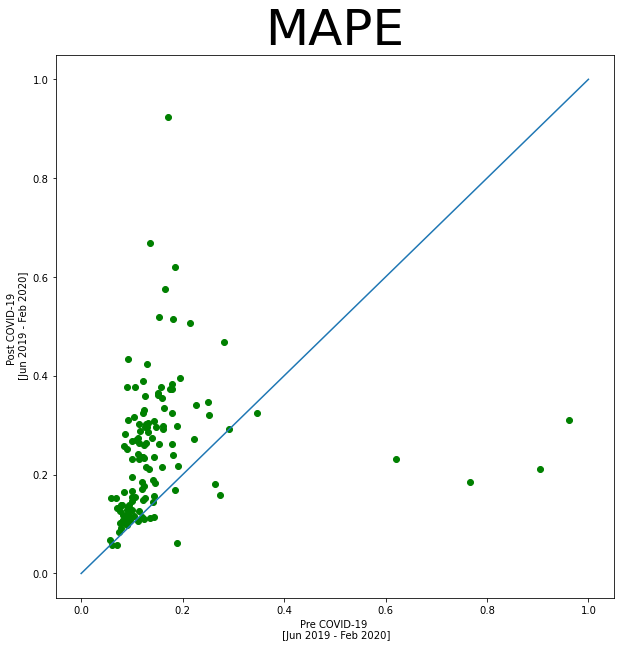

In [182]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
axs.scatter(a.pre_MAPE, a.post_MAPE, color="g")
axs.plot([0, 1], [0, 1])
axs.set_ylabel('Post COVID-19 \n [Jun 2019 - Feb 2020]')
axs.set_xlabel('Pre COVID-19 \n [Jun 2019 - Feb 2020]')
axs.set_title('MAPE', fontsize = 50)

Text(0.5, 1.0, 'VAPE')

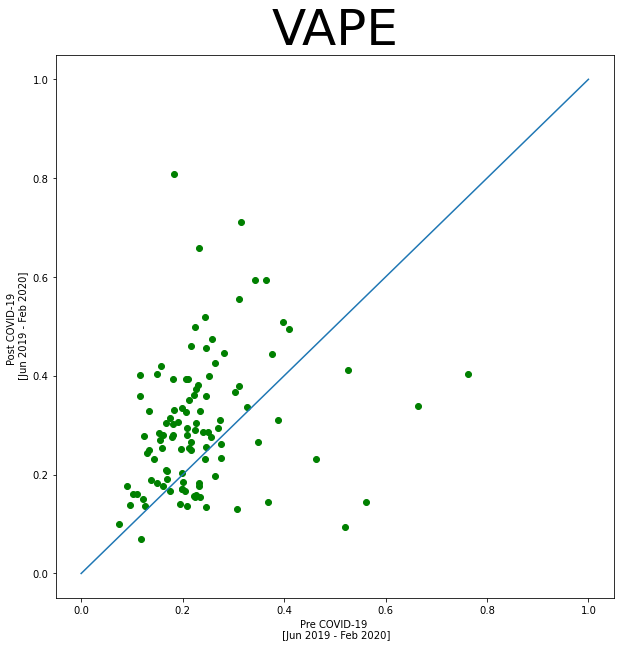

In [185]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
axs.scatter(b.pre_VAPE, b.post_VAPE, color="g")
axs.plot([0, 1], [0, 1])
axs.set_ylabel('Post COVID-19 \n [Jun 2019 - Feb 2020]')
axs.set_xlabel('Pre COVID-19 \n [Jun 2019 - Feb 2020]')
axs.set_title('VAPE', fontsize = 50)

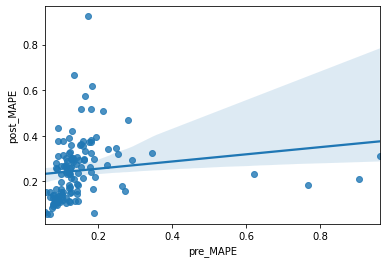

In [174]:
import seaborn as sns
ax = sns.regplot(x="pre_MAPE", y="post_MAPE", data=a)


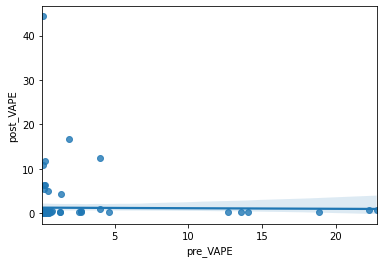

In [169]:
ax = sns.regplot(x="pre_VAPE", y="post_VAPE", data=VAPE_df)

In [116]:
arima_models.pre.columns[arima_models.pre.columns.str.contains('09107')]

Index(['(09107) Hortúa'], dtype='object')

In [119]:
arima_models.pre['(09107) Hortúa']

1096    348.520973
1097    345.151332
1098    346.447654
1099    304.763590
1100    236.340645
           ...    
1669    341.848632
1670    332.678614
1671    342.382202
1672    343.530133
1673    309.433666
Name: (09107) Hortúa, Length: 578, dtype: float64

In [122]:
'(09107) Hortúa' == '(09107) Hortúa'

False

In [142]:
a = '(09107) Hortúa'
print (a.encode())
print(type(a))

b'(09107) Hortu\xcc\x81a'
<class 'str'>


In [143]:
b = '(09107) Hortúa'
print (b.encode())
print(type(b))

b'(09107) Hort\xc3\xbaa'
<class 'str'>


In [145]:
a.encode('utf-8')

b'(09107) Hortu\xcc\x81a'

In [146]:
b.encode('utf-8')

b'(09107) Hort\xc3\xbaa'

In [127]:

arima_models.pre['(09107) Hortúa']

KeyError: '(09107) Hortúa'

In [95]:
post_MAPE_list

[0.32484278081007234]

In [111]:
out_folder = 'output/arima/results/day'
stations_list = os.listdir(out_folder)
stations_list = [x.split('.json')[0] for x in stations_list]#removes extension in file name

In [110]:
stations_list 

['(09111) Calle 19',
 '(07103) AV. CHILE',
 '(10000) Portal 20 de Julio',
 '(07107) U. NACIONAL',
 '(06105) Quinta Paredes',
 '(08000) Portal Tunal',
 '(08001) Parque el Tunal',
 '(03004) GRATAMIRA',
 '(07009) SENA',
 '(09107) Hortúa',
 '(03002) SUBA - TV- 91',
 '(07503) SAN MATEO',
 '(10010) San Bernardo',
 '(09118) Marly',
 '(10001) Country Sur',
 '(07104) Simon Bolivar',
 '(09123) Calle 76',
 '(07200) Tygua-San José',
 '(07008) NQS - Calle 30 Sur',
 '(02300) Calle 100',
 '(06109) Centro Memoria',
 '(02001) Centro Comercial Santa Fe',
 '(09004) Santa Lucía',
 '(07002) MADELENA',
 '(05105) Pradera',
 '(07005) ALQUERIA',
 '(04108) El Polo',
 '(09110) Avenida Jimenez',
 '(03007) HUMEDAL CORDOBA',
 '(02304) Heroes',
 '(07108) Av. El Dorado',
 '(09108) Hospital',
 '(07000) Portal Sur',
 '(09113) Calle 22',
 '(06101) El Tiempo',
 '(04103) Las Ferias',
 '(10003) Ciudad Jardín',
 '(14005) Las Aguas',
 '(07106) EL CAMPIN',
 '(09101) Quiroga',
 '(04107) Escuela Militar',
 '(04001) Quirigua

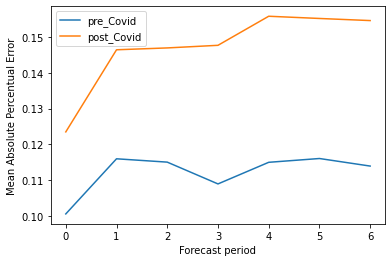

In [123]:
#Organize true values in a nx7 prediction 
pre_data = arima_models.pre[station]
shift_list = []
col_list = []
for i in range(7):
    shift_list.append(pre_data.shift(-i))
    col_list.append('forecast_period_' + str(i + 1))
pre_true= pd.concat(shift_list, axis = 1)
pre_true.columns = col_list
pre_true = np.array(pre_true.dropna())
pre_forecast = prediction[:572,:]

# True values post_covid 
post_data = arima_models.post[station]
shift_list = []
col_list = []
for i in range(7):
    shift_list.append(post_data.shift(-i))
    col_list.append('forecast_period_' + str(i + 1))
post_true= pd.concat(shift_list, axis = 1)
post_true.columns = col_list
post_true = np.array(post_true.dropna())
post_true = post_true[:420,:]
post_forecast = prediction_post[:420,:]

# Estiamte error 
##################
#pre
error = (pre_true - pre_forecast)/pre_true
APE = np.abs((pre_true - pre_forecast)/pre_true)
average_error_pre = APE.mean(axis = 0)
vape_pre = APE.std(axis = 0)
#post 
APE = np.abs((post_true - post_forecast)/post_true)
average_error_post = APE.mean(axis = 0)
vape_post = APE.std(axis = 0)

#Plot
plt.plot(average_error_pre, label = 'pre_Covid')
plt.plot(average_error_post, label = 'post_Covid')
plt.ylabel('Mean Absolute Percentual Error')
plt.xlabel('Forecast period')
plt.legend()

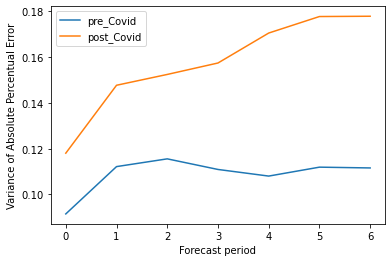

In [125]:
#Plot
plt.plot(vape_pre, label = 'pre_Covid')
plt.plot(vape_post, label = 'post_Covid')
plt.ylabel('Variance of Absolute Percentual Error')
plt.xlabel('Forecast period')
plt.legend()

In [149]:
#pre
error = (pre_true - pre_forecast)/pre_true
APE_pre = np.abs((pre_true - pre_forecast)/pre_true)
average_error_pre = APE_pre.mean(axis = 0)
vape_pre = APE_pre.std(axis = 0)

#post 
APE_post = np.abs((post_true - post_forecast)/post_true)
average_error_post = APE_post.mean(axis = 0)
vape_post = APE_post.std(axis = 0)

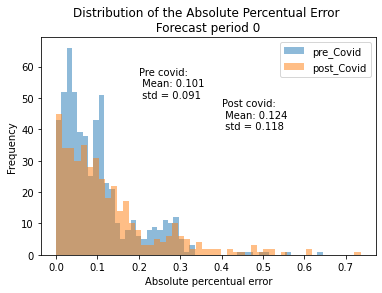

In [154]:
plt.hist(APE_pre[:,0], bins = 50, alpha = 0.5, label = 'pre_Covid');
plt.hist(APE_post[:,0], bins = 50, alpha = 0.5, label = 'post_Covid');
plt.text(0.2,50, "Pre covid: \n Mean: {:.3f} \n std = {:.3f}".format(np.mean(APE_pre[:,0]), np.std(APE_pre[:,0])))
plt.text(0.4,40, "Post covid: \n Mean: {:.3f} \n std = {:.3f}".format(np.mean(APE_post[:,0]), np.std(APE_post[:,0])))
plt.xlabel('Absolute percentual error')
plt.ylabel('Frequency')
plt.title('Distribution of the Absolute Percentual Error \n Forecast period 0 ')
plt.legend();

In [191]:
mape_time_series = np.concatenate((APE_pre.mean(axis = 1), APE_post.mean(axis = 1)))
std_time_series = np.concatenate((APE_pre.std(axis = 1), APE_post.std(axis = 1)))

In [192]:
pre_data = arima_models.pre
post_data = arima_models.post

In [193]:
data_pre = pre_data.year.astype(str) + '-'+ pre_data.month.astype(str)
data_post = post_data.year.astype(str) + '-'+ post_data.month.astype(str)
date = np.concatenate((data_pre, data_post))

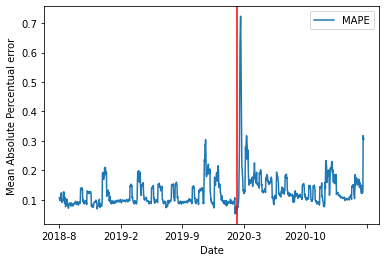

In [212]:
df = pd.DataFrame({'Date':date[:992], 'MAPE': mape_time_series, 'VAPE': std_time_series})
df.plot(x = 'Date', y = 'MAPE')
plt.ylabel('Mean Absolute Percentual error')
plt.axvline(578, color = 'r')

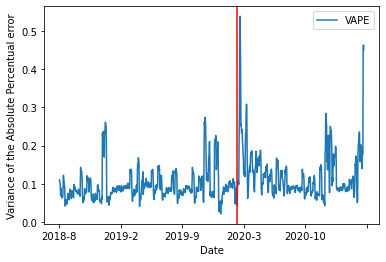

In [213]:
df.plot(x = 'Date', y = 'VAPE')
plt.ylabel('Variance of the Absolute Percentual error')
plt.axvline(578, color = 'r')